In [1]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import ipywidgets as widgets

import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.boost.anyboost as anyboost
import mlgrad.inventory as inventory
import mlgrad.plots as plots

In [2]:
X, Y = datasets.make_moons(200, noise=0.35)
Y = 2*Y-1
Y = Y.astype("d")

Xt, Yt = datasets.make_moons(200, noise=0.35)
Yt = 2*Yt-1
Yt = Yt.astype("d")

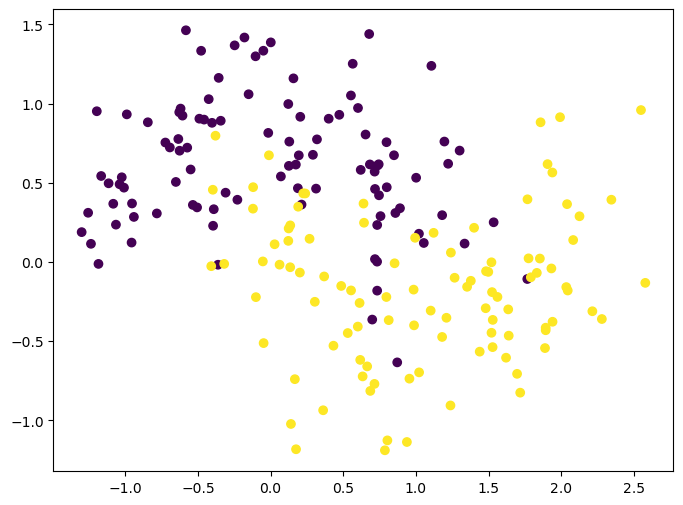

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [11]:
def sigmoidal_factory(n):
    mod = models.SigmaNeuronModel(funcs.Sigmoidal(3.0), n)
    # mod.use_regularizer(funcs2.SquareNorm(), 0.1)
    return mod

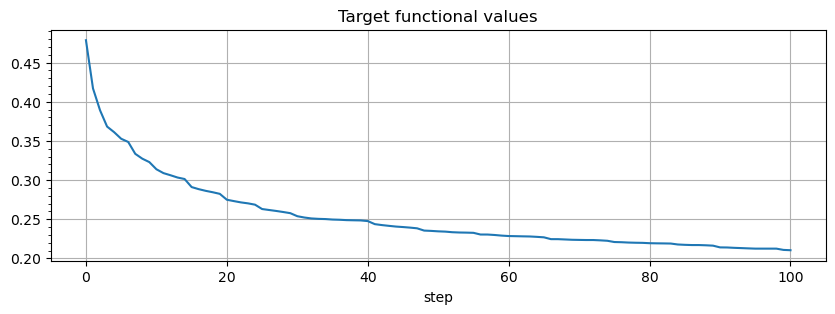

In [12]:
XX, YY = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.0, 100))
XY = np.c_[XX.ravel(), YY.ravel()]    

# def callback1(cls):
#     fig=plt.figure("anyboost1", figsize=(6,4))
#     fig.clear()
#     ZZ = np.sign(cls.H.evaluate(XY))
#     ZZ = ZZ.reshape(XX.shape)
#     plt.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
#     plt.contour(ZZ, extent=(-1.5, 2.5, -1.5,2.0), levels=[0], colors=["darkblue"])
#     fig.canvas.flush_events()

cls = anyboost.AnyBoostClassification(
    func=funcs.SoftHinge_Exp(1.0),
    lossfunc=loss.MarginLoss(funcs.Hinge()),
    model_factory=sigmoidal_factory, 
    # callback=callback1,
    shrink=0.1,
    # min_weak_learn_score=0.01,
    n_classifier=100)

# plt.ioff()
cls.fit(X, Y, h=0.01)
# print(cls.H.models[0].regfunc)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

In [13]:
print("Classifier accuracy:", metrics.accuracy_score(np.sign(cls.H.evaluate(X)),Y))
print("Classifier accuracy:", metrics.accuracy_score(np.sign(cls.H.evaluate(Xt)),Yt))

Classifier accuracy: 0.9
Classifier accuracy: 0.875


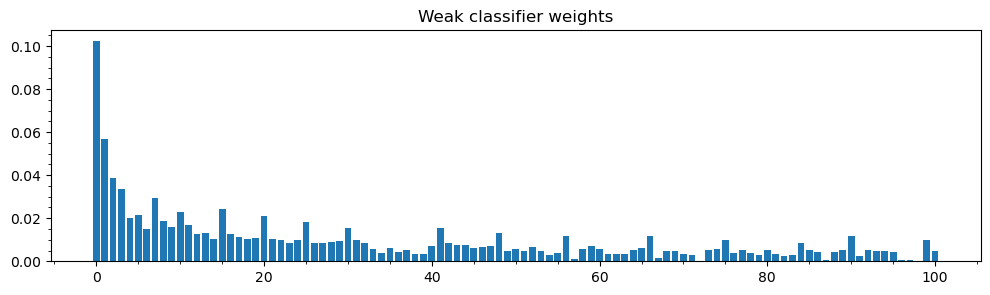

In [14]:
plt.figure(figsize=(12,3))
plt.title("Weak classifier weights")
plt.bar(range(len(cls.H.weights)), cls.H.weights)
plt.minorticks_on()
plt.show()

In [15]:
scores = np.array([metrics.accuracy_score(np.sign(mod.evaluate(X)),Y) for mod in cls.H.models])
# print((scores>0.5).sum(), (scores<0.5).sum())

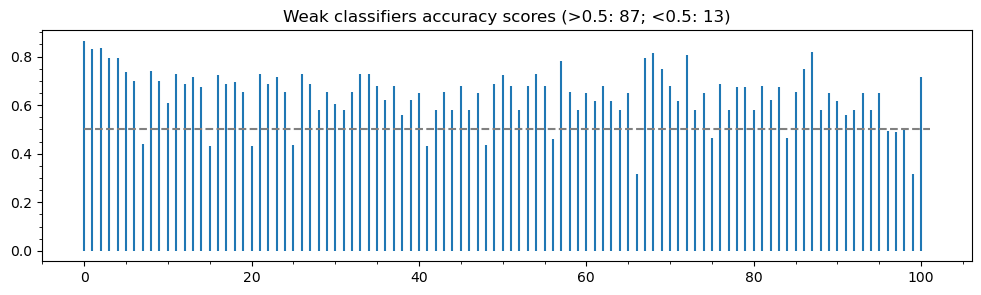

In [16]:
plt.figure(figsize=(12,3))
plt.title(f"Weak classifiers accuracy scores (>0.5: {(scores>0.5).sum()}; <0.5: {(scores<0.5).sum()})")
plt.vlines(range(len(scores)), 0, scores)
plt.hlines(0.5, 0, len(scores), colors='grey', linestyles='--')
plt.minorticks_on()
plt.show()

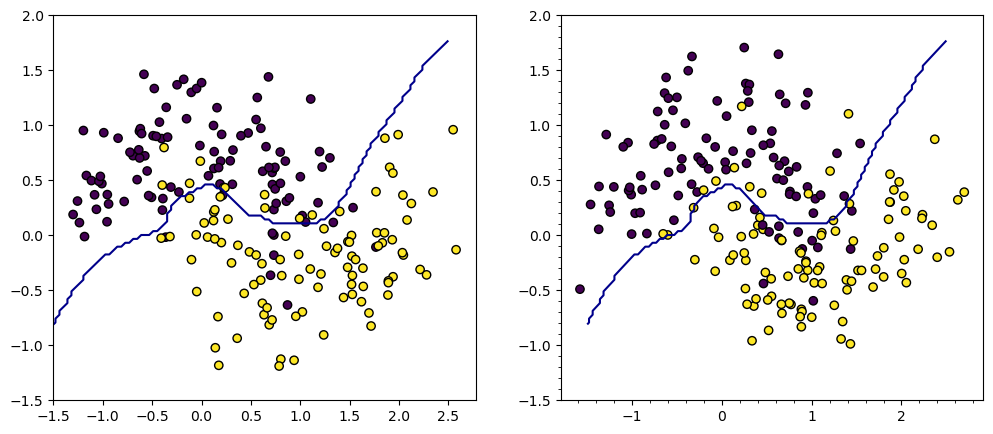

In [17]:
plt.figure(figsize=(12,5))
XX, YY = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.0, 100))
XY = np.c_[XX.ravel(), YY.ravel()]
plt.subplot(1,2,1)
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
plt.contour(ZZ, extent=(-1.5, 2.5, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.subplot(1,2,2)
ZZ2 = np.sign(cls.H.evaluate(XY))
ZZ2 = ZZ2.reshape(XX.shape)
plt.scatter(Xt[:,0], Xt[:,1], c=Yt, edgecolors='k')
plt.contour(ZZ2, extent=(-1.5, 2.5, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.show()

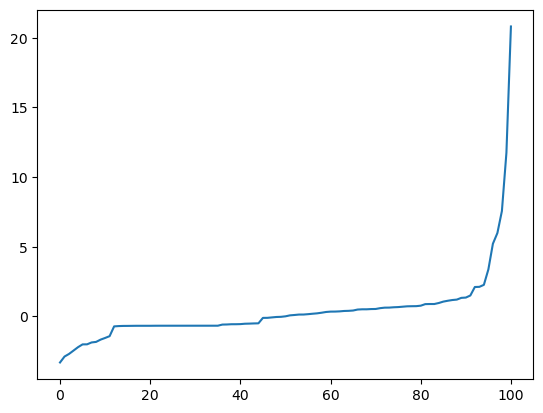

In [11]:
YYW = np.array([Y @ wm.evaluate(X) for wm in cls.H.models]) * cls.H.weights
ZYYW = inventory.modified_zscore(YYW)
# plt.plot(sorted(YYW), )
# plt.show()
plt.plot(sorted(ZYYW),)
plt.show()

In [12]:
M = cls.H.evaluate(X) * Y
ZM = inventory.modified_zscore(M)

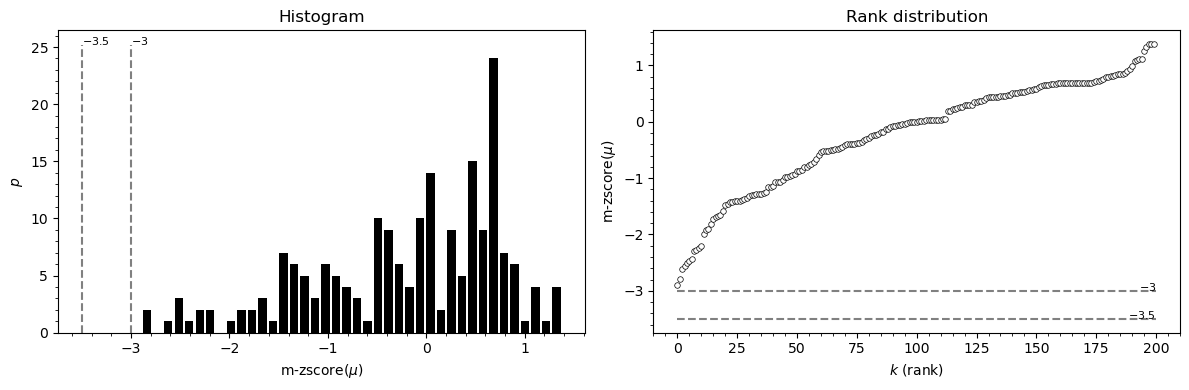

In [13]:
# plots.plot_hist_and_rank_distribution(M, levels=[0], ylabel=fr"$\mu$")
plots.plot_hist_and_rank_distribution(ZM, levels=[-3.5,-3], ylabel=fr"m-zscore$(\mu)$")

In [14]:
X_p = X[M >= -3]
Y_p = Y[M >= -3]

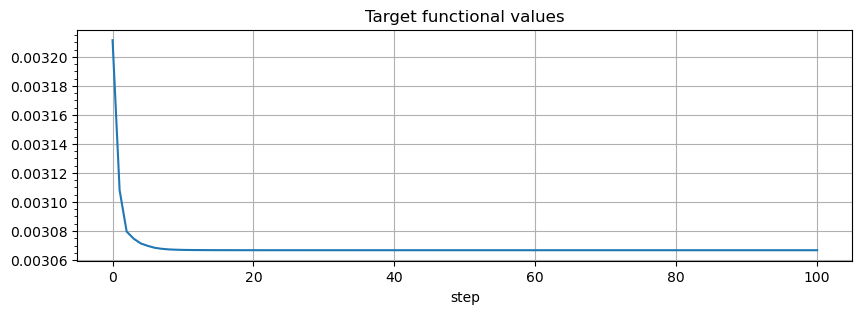

In [15]:
cls2 = anyboost.AnyBoostClassification(
    func=funcs.SoftHinge_Sqrt(0.01), 
    # lossfunc=loss.MarginLoss(funcs.SoftHinge_Sqrt()),
    model_factory=sigmoidal_factory, 
    shrink=0.001,
    # min_weak_learn_score=0.01,
    n_classifier=100)
cls2.fit(X_p, Y_p, regnorm=funcs2.SquareNorm(), tau=1.0)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls2.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

In [16]:
print("Classifier accuracy:", metrics.accuracy_score(np.sign(cls2.H.evaluate(X)),Y))
print("Classifier accuracy:", metrics.accuracy_score(np.sign(cls2.H.evaluate(Xt)),Yt))

Classifier accuracy: 0.845
Classifier accuracy: 0.805


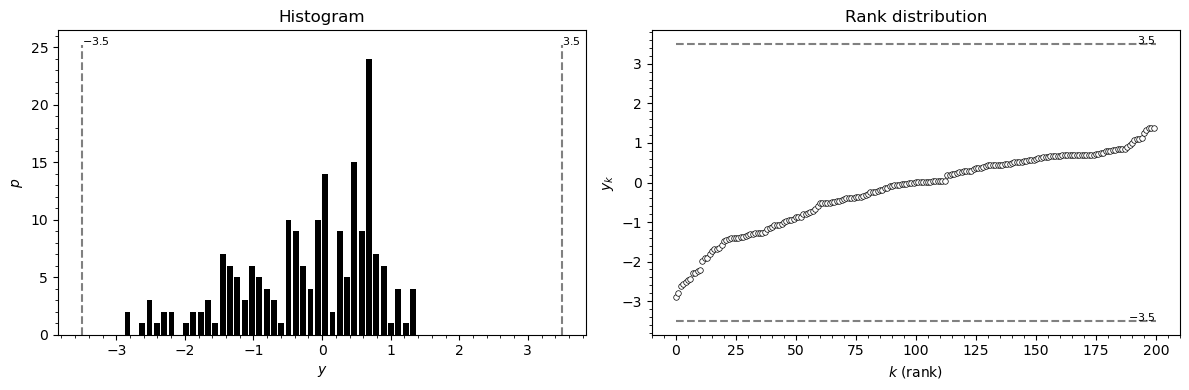

In [17]:
M2 = cls.H.evaluate(X_p) * Y_p
ZM2 = inventory.modified_zscore(M2)
plots.plot_hist_and_rank_distribution(ZM2, levels=[-3.5, 3.5])

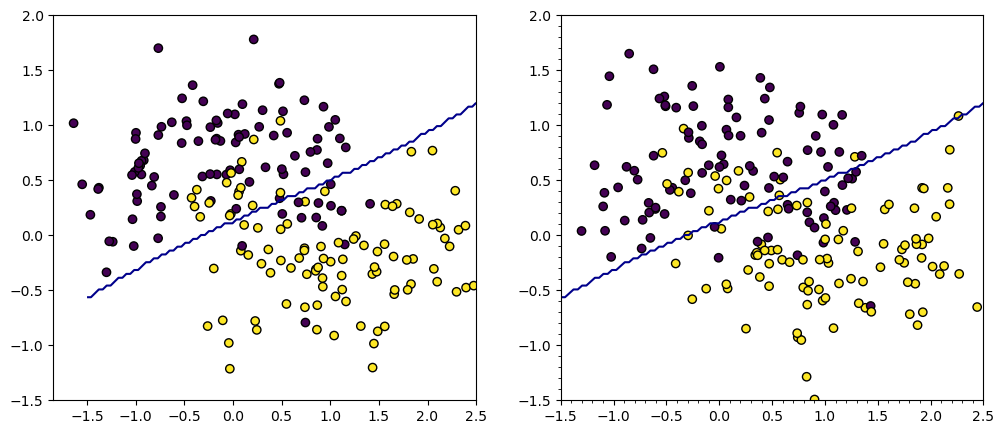

In [18]:
plt.figure(figsize=(12,5))
XX, YY = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 2.0, 100))
XY = np.c_[XX.ravel(), YY.ravel()]
plt.subplot(1,2,1)
ZZ = np.sign(cls2.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
plt.contour(ZZ, extent=(-1.5, 2.5, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.subplot(1,2,2)
ZZ2 = np.sign(cls2.H.evaluate(XY))
ZZ2 = ZZ2.reshape(XX.shape)
plt.scatter(Xt[:,0], Xt[:,1], c=Yt, edgecolors='k')
plt.contour(ZZ2, extent=(-1.5, 2.5, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.show()

In [19]:
# scores = []
# scores_t = []
# for i in range(22):
#     X, Y = datasets.make_moons(200, noise=0.3)
#     Y = 2*Y-1
#     Y = Y.astype("d")
    
#     Xt, Yt = datasets.make_moons(200, noise=0.3)
#     Yt = 2*Yt-1
#     Yt = Yt.astype("d")

#     cls = anyboost.AnyBoostClassification(
#         func=funcs.SoftHinge_Exp(), 
#         model_factory=sigmoidal_factory, 
#         # shrink=0.2,
#         # min_weak_learn_score=0.01,
#         n_classifier=100)
#     cls.fit(X, Y, regnorm=funcs2.SquareNorm(), tau=1.0)
#     scores.append(metrics.accuracy_score(np.sign(cls.H.evaluate(X)), Y))
#     scores_t.append(metrics.accuracy_score(np.sign(cls.H.evaluate(Xt)), Yt))

# print(np.mean(scores),   np.std(scores))
# print(np.mean(scores_t), np.std(scores_t))